In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from datetime import datetime

import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset, save_dataset, load_dataset
# from src.TFT_Flowmatching import TemporalFusionTransformerDiffusion

from src.VQVAE import VQVAE
from typing import Optional
import pickle

import torch.utils
import torch.utils.data

## Optional: direct load data from Cache

In [ ]:
# train = load_dataset('../data/.cache/train.pkl')
# test = load_dataset('../data/.cache/test.pkl')
# stats_dict = pickle.load(open('../data/.cache/stats_dict.pkl', 'rb'))
# feature_dim = stats_dict['feature_dim']
# features = stats_dict['features']

lookback = 30
future_steps = 40
resample = False
dir = '../data/Phase3/Modified/'
ds = MyDataset(lookback=lookback)
train_batch_size = 16
test_batch_size = 64

In [ ]:


def process_data(df_dir : str, target_freq : int = 10):
    states = ['At Station', 'Error', 'Wait', 'Cross', 'Approach Sidewalk',
       'Approach Target Station', 'Move Along Sidewalk']

    states_ohe = pd.get_dummies(df['state'], prefix='state')
    cur_states = df['state'].unique()
    for state in states:
        if state not in cur_states:
            states_ohe['state_'+state] = 0

    df = pd.concat([df, states_ohe], axis=1)
    df.drop(columns=['state'], inplace=True)
    
    df.dropna(inplace=True, how='any')
    if resample:
        f_per_sec = df.groupby('TimestampID').count().mean().mean()
        if f_per_sec < target_freq:
            raise ValueError('The frequency of the data is lower than the target frequency')
        elif int(f_per_sec) == target_freq:
            pass
        else:
            resample_ratio = int(f_per_sec/target_freq)
            df = df.iloc[::resample_ratio, :]
    # # for origin
    for drop_column in ['Confidence', 'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget', 
                          'start_station_X', 'start_station_Y', 'end_station_X', 'end_station_Y',
                          'distance_from_start_station_X',
                            'distance_from_start_station_Y', 'distance_from_end_station_X',
                            'distance_from_end_station_Y', 'facing_start_station',
                            'facing_end_station', 
                            'rolling_avg', 
                            'User', 'Type', 
                            'possible_interaction'
                          ]:
        df = df.drop(columns=[drop_column], errors='ignore')

    target_columns = ['User_X', 'User_Y']
    # Reorder columns
    new_columns = target_columns + [col for col in df.columns if col not in target_columns]
    df = df[new_columns]
    
    # keep numeric columns
    df = df.apply(pd.to_numeric, errors='ignore')

    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df, agv_col_name="scenario")


### Optional: shuffle the dataset

In [3]:
# import random
# random.shuffle(ds.dataset)

In [19]:
stats_dict = {'mean': 0, 'std': 0, 'min': 0, 'max': 0}
stats_dict = ds.normalize_dataset()
ds.generate_data(future_steps=future_steps)

train:torch.utils.data.DataLoader
test:torch.utils.data.DataLoader

train, test = ds.split_data(frac=0.9, shuffle=True, train_batch_size=train_batch_size, test_batch_size=test_batch_size)

feature_dim = ds.feature_dim
stats_dict['feature_dim'] = feature_dim
stats_dict['features'] = ds.dataset[0].columns
columns = [_ for _ in ds.dataset[0].columns if _ not in ['AGV_name']]
print(f"columns : {df.columns} \nfeature_dim : {feature_dim}")

columns : Index(['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'facing_along_sidewalk',
       'facing_to_road', 'On_sidewalks', 'On_road', 'closest_station',
       'distance_to_closest_station', 'distance_to_closest_station_X',
       'distance_to_closest_station_Y', 'looking_at_AGV', 'GazeDirection_X',
       'GazeDirection_Y', 'GazeDirection_Z', 'AGV_X', 'AGV_Y',
       'looking_at_closest_station', 'data_active', 'scenario',
       'state_Approach Sidewalk', 'state_Approach Target Station',
       'state_At Station', 'state_Cross', 'state_Error',
       'state_Move Along Sidewalk', 'state_Wait'],
      dtype='object') 
feature_dim : 38


['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
       'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
       'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
       'intent_to_cross', 'Gazing_station', 'possible_interaction',
       'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
       'closest_station', 'distance_to_closest_station',
       'distance_to_closest_station_X', 'distance_to_closest_station_Y',
       'looking_at_AGV', 'GazeDirection_X', 'GazeDirection_Y',
       'GazeDirection_Z', 'AGV_X', 'AGV_Y', 'looking_at_closest_station']

In [4]:
for i, (X, y) in enumerate(train):
    print(X.shape, y.shape)
    break

print(len(train) * train_batch_size, len(test) * test_batch_size)

# save it to cache to speed up
# save_dataset(train, type='train', file_path='../data/.cache/train.pkl')
# save_dataset(test, type='test', file_path='../data/.cache/test.pkl')
# pickle.dump(stats_dict, open('../data/.cache/stats_dict.pkl', 'wb'))


torch.Size([16, 30, 38]) torch.Size([16, 40, 38])
317840 35328


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional
from src.VQVAE import VQVAE
import math

###############################################
# Original Blocks (with minor efficiency tweaks)
###############################################

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout_rate=0.1):
        super(GatedResidualNetwork, self).__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)]
        )
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(input_size, output_size)
        self.gate = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x_input = x
        for layer, norm in zip(self.layers, self.norms):
            x = F.relu(layer(x))
            x = self.dropout(x)
            x = norm(x)
        gate = torch.sigmoid(self.gate(x))
        x2 = self.fc2(x)
        return self.fc3(x_input) + gate * x2

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout_rate)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size * 4, hidden_size)
        )

    def forward(self, x, mask: Optional[torch.Tensor] = None):
        # x: (seq_len, batch, hidden_size)
        x2 = x
        x = self.norm1(x)
        x, _ = self.attention(x, x, x, key_padding_mask=mask)
        x = x + x2
        x2 = x
        x = self.norm2(x)
        x = self.feed_forward(x)
        x = x + x2
        return x

###############################################
# Diffusion–based Decoder
###############################################

class SinusoidalTimeEmbedding(nn.Module):
    """
    Computes a sinusoidal embedding for a scalar timestep.
    """
    def __init__(self, embedding_dim):
        super(SinusoidalTimeEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        # t: Tensor of shape (batch,) or (batch, 1)
        if len(t.shape) == 1:
            t = t.unsqueeze(1)  # (batch, 1)
        half_dim = self.embedding_dim // 2
        # Compute constant
        emb_factor = math.log(10000) / (half_dim - 1)
        # Create a tensor of shape (half_dim,)
        dims = torch.arange(half_dim, device=t.device, dtype=t.dtype)
        # (batch, half_dim)
        emb = t * torch.exp(-dims * emb_factor)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        # If embedding_dim is odd, pad an extra zero.
        if self.embedding_dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb  # (batch, embedding_dim)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

class DiffusionDecoder(nn.Module):
    def __init__(self, action_dim, conditioning_dim, num_diffusion_steps=10,
                 num_action_steps=20, num_heads=4, hidden_dim=128, num_layers=2):
        super().__init__()
        self.action_dim = action_dim
        self.num_diffusion_steps = num_diffusion_steps
        self.hidden_dim = hidden_dim
        self.num_action_steps = num_action_steps

        # Improved beta schedule
        betas = cosine_beta_schedule(num_diffusion_steps)
        self.register_buffer('betas', betas)
        alphas = 1.0 - betas
        self.register_buffer('alpha_bars', torch.cumprod(alphas, dim=0))

        # Enhanced time embedding
        self.time_embed = SinusoidalTimeEmbedding(hidden_dim)
        
        # Input projection with time conditioning
        self.input_proj = nn.Linear(action_dim + hidden_dim, hidden_dim)

        # Transformer blocks with cross-attention
        self.blocks = nn.ModuleList([
            nn.ModuleDict({
                'cross_attn': nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True),
                'mlp': nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim * 4),
                    nn.GELU(),
                    nn.Linear(hidden_dim * 4, hidden_dim)
                ),
                'norm1': nn.LayerNorm(hidden_dim),
                'norm2': nn.LayerNorm(hidden_dim),
            }) for _ in range(num_layers)
        ])

        # Final output projection
        self.out = nn.Linear(hidden_dim, action_dim)

    def forward(self, conditioning, x_t, t):
        # Time embedding
        t_emb = self.time_embed(t)  # [batch, h_dim]
        
        # Combine input with time embeddings
        x_proj = self.input_proj(torch.cat([x_t, t_emb.unsqueeze(1).expand(-1, x_t.size(1), -1)], -1))
        
        # Process through transformer blocks
        h = x_proj
        for block in self.blocks:
            # Cross-attention
            attn_out, _ = block['cross_attn'](
                h, conditioning, conditioning,
            )
            h = h + attn_out
            h = block['norm1'](h)
            
            # MLP
            h = h + block['mlp'](h)
            h = block['norm2'](h)
        
        return self.out(h)
    
    def influence(self, conditioning, device):
        """
        Runs the reverse diffusion process and returns a list of intermediate denoised trajectories.
        
        Args:
            conditioning: Tensor of shape (batch, cond_len, conditioning_dim)
            device: torch.device.
            
        Returns:
            intermediates: A list of tensors, each of shape (batch, num_action_steps, action_dim),
                           representing the denoised trajectory at each diffusion step.
        """
        batch_size = conditioning.size(0)
        x = torch.randn(batch_size, self.num_action_steps, self.action_dim, device=device)
        intermediates = []
        # Reverse diffusion: record intermediate results at each step.
        for t in reversed(range(self.num_diffusion_steps)):
            t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
            epsilon_pred = self.forward(conditioning, x, t_tensor)
            beta_t = self.betas[t]
            alpha_t = 1.0 - beta_t
            alpha_bar_t = self.alpha_bars[t]
            noise = torch.randn_like(x) if t > 0 else 0.0
            x = (1.0 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * epsilon_pred) \
                + torch.sqrt(beta_t) * noise
            # Save a clone of the current state.
            intermediates.append(x.clone())
        return intermediates
    

    def sample(self, conditioning, device):
        """
        Generate a trajectory by running the reverse diffusion process.
        
        Args:
            conditioning: Tensor of shape (batch, cond_len, conditioning_dim)
            device: torch.device to run the sampling on.
            
        Returns:
            x: Generated trajectory of shape (batch, num_action_steps, action_dim)
        """
        batch_size = conditioning.size(0)
        # Start from standard Gaussian noise.
        x = torch.randn(batch_size, self.num_action_steps, self.action_dim, device=device)
        # Reverse diffusion process (using the DDPM update)
        for t in reversed(range(self.num_diffusion_steps)):
            t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
            epsilon_pred = self.forward(conditioning, x, t_tensor)
            beta_t = self.betas[t]
            alpha_t = 1.0 - beta_t
            alpha_bar_t = self.alpha_bars[t]
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0.0
            # DDPM reverse update:
            x = (1.0 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * epsilon_pred) \
                + torch.sqrt(beta_t) * noise
        return x
    
###############################################
# Modified Temporal Fusion Transformer with Diffusion Decoder
###############################################

class TemporalFusionTransformerDiffusion(nn.Module):
    def __init__(self, num_features, num_hidden, num_outputs, num_steps,
                 num_attention_heads=8, diffusion_steps=10, vqvae: VQVAE = None):
        """
        Args:
            num_features (int): Number of input features.
            num_hidden (int): Hidden dimension size.
            num_outputs (int): Dimensionality of each output (e.g. action dimension).
            num_steps (int): Desired output sequence length (e.g. number of action steps).
            num_attention_heads (int): Number of heads for the transformer blocks.
            diffusion_steps (int): Number of diffusion (denoising) steps.
        """
        super(TemporalFusionTransformerDiffusion, self).__init__()
        if vqvae is None:
            self.vqvae = VQVAE(input_dim=feature_dim, hidden_dim=512, num_embeddings=128, embedding_dim=128, commitment_cost=0.25)
        else:
            self.vqvae = vqvae
        num_features = num_features + self.vqvae.encoder.fc2.out_features
        self.encoder_grn = GatedResidualNetwork(num_features, num_hidden, num_hidden)
        self.transformer_block = TransformerBlock(num_hidden, num_heads=num_attention_heads, dropout_rate=0.1)
        self.transformer_block2 = TransformerBlock(num_hidden, num_heads=num_attention_heads, dropout_rate=0.1)
        
        # To condition the diffusion process we project the transformer output.
        self.condition_proj = nn.Linear(num_hidden, num_hidden)
        # Diffusion decoder: we set action_dim=num_outputs and produce a sequence of length num_steps.
        self.diffusion_decoder = DiffusionDecoder(
            action_dim=num_outputs,
            conditioning_dim=num_hidden,
            num_diffusion_steps=diffusion_steps,
            num_action_steps=num_steps,
            num_heads=4,  # you can adjust as needed
            hidden_dim=num_hidden
        )

        self.num_steps = num_steps
        self.num_outputs = num_outputs

    def forward(self, x, y_batch=None , mask: Optional[torch.Tensor] = None, influence=False, return_all=False):
        """
        Args:
            x: Input tensor of shape (batch, seq_len, num_features).
            mask: Optional attention mask for the transformer blocks.
            
        Returns:
            actions: Tensor of shape (batch, num_steps, num_outputs)
        """
        # If given a 2D input, add a batch dimension.
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        batch_size, seq_len, _ = x.shape

        # VQ-VAE
        x_recon, vq_loss, perplexity, embedding = self.vqvae(x)
        x = torch.cat((x, embedding), dim=-1)
        
        # Encoder GRN.
        x = self.encoder_grn(x)  # (batch, seq_len, num_hidden)
        
        # Transformer expects (seq_len, batch, hidden_size).
        x = x.permute(1, 0, 2)
        x = self.transformer_block(x, mask=mask)
        x = self.transformer_block2(x, mask=mask)
        x = x.permute(1, 0, 2)  # back to (batch, seq_len, num_hidden)
        
        # Use a summary of the encoder output as conditioning.
        # Here we use the last time–step (you might also try an average or more complex pooling).
        conditioning = self.condition_proj(x[:, -1:, :])  # (batch, 1, num_hidden)
        # conditioning = self.condition_proj(x[:, :, :])  # (batch, 1, num_hidden)



        # flow matching during training
        self.device = next(self.parameters()).device
        flow_loss = torch.tensor(0.0, device=self.device)

        
        if influence:
            if return_all:
                return self.diffusion_decoder.influence(conditioning, self.device)
            return self.diffusion_decoder.influence(conditioning, self.device)[-1]
        else:
            if self.training:
                diff_loss = self.decoder_train_step(conditioning, y_batch, self.device)
                return diff_loss, vq_loss, perplexity, flow_loss
            
            return User_trajectory, vq_loss, perplexity, flow_loss


    def influence(self, x):
        User_trajectory = self.forward(x, influence=True)
        return User_trajectory
    
    def decoder_train_step(self, conditioning, y_batch, device):
        """
        Performs one training step for the diffusion self.diffusion_decoder.
        
        Args:
            self.diffusion_decoder: Instance of DiffusionDecoder.
            conditioning: Conditioning tensor (batch, cond_len, conditioning_dim)
                        (e.g., output from an encoder that has been projected to hidden_dim).
            y_batch: Ground truth trajectory (batch, num_action_steps, action_dim).
            device: torch.device.
            
        Returns:
            loss: The MSE loss between predicted and true noise.
        """
        batch_size = y_batch.size(0)
        # Sample random timesteps for each example in the batch.
        t = torch.randint(0, self.diffusion_decoder.num_diffusion_steps, (batch_size,), device=device)
        # Gather the corresponding alpha_bar for each timestep.
        alpha_bar_t = self.diffusion_decoder.alpha_bars[t].view(batch_size, 1, 1)  # (batch, 1, 1)
        # Sample noise to add.
        noise = torch.randn_like(y_batch)
        # Create the noisy trajectory: x_t = sqrt(alpha_bar) * x0 + sqrt(1 - alpha_bar) * noise
        x_t = torch.sqrt(alpha_bar_t) * y_batch + torch.sqrt(1.0 - alpha_bar_t) * noise
        # The network predicts the noise given x_t and the conditioning.
        noise_pred = self.diffusion_decoder(conditioning, x_t, t)
        # MSE loss between the predicted noise and the actual noise.
        loss = F.mse_loss(noise_pred, noise)
        return loss

def compute_flow_target(noise, target, t, schedule_fn=lambda t: t):
    """
    Computes an intermediate sample x_t and its target flow v_target.
    
    Args:
        noise: Tensor of shape (batch, num_action_steps, action_dim)
        target: Ground truth output tensor of shape (batch, num_action_steps, action_dim)
        t: Tensor of shape (batch, 1, 1) with time values in [0,1]
        schedule_fn: A function φ(t) that maps time to interpolation weight.
                     For a linear schedule, schedule_fn(t)=t.
                     
    Returns:
        x_t: The intermediate sample at time t.
        v_target: The target flow, i.e., d x_t / dt.
    """
    # Compute interpolation weight and its derivative.
    phi = schedule_fn(t)              # shape: (batch, 1, 1)
    # For linear schedule, dphi/dt = 1. Otherwise, adjust accordingly.
    dphi_dt = torch.ones_like(phi)    # Modify if using a non-linear schedule.
    
    # Interpolate: x(t) = (1 - φ(t)) * noise + φ(t) * target
    x_t = (1 - phi) * noise + phi * target
    
    # The target flow is: v_target = dφ/dt * (target - noise)
    v_target = dphi_dt * (target - noise)
    
    return x_t, v_target


In [6]:
class DecayLoss(nn.Module):
    def __init__(self, num_steps, baseline_loss_fn=nn.L1Loss()):
        super(DecayLoss, self).__init__()
        # Weight decreases as we move further into the future
        self.weights = torch.linspace(1.0, 1.0, num_steps)
        self.baseline_loss_fn = baseline_loss_fn
        

    def forward(self, predictions, targets):
        loss = 0
        for i in range(predictions.shape[1]):
            loss += self.weights[i] * self.baseline_loss_fn(predictions[:, i], targets[:, i])
        return loss
    
    
baseline_loss_fn = nn.L1Loss() #nn.MSELoss()
loss_fn = DecayLoss(future_steps, baseline_loss_fn=baseline_loss_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

vqvae = VQVAE(input_dim=feature_dim, hidden_dim=512, num_embeddings=128, embedding_dim=128, commitment_cost=0.25)

model = TemporalFusionTransformerDiffusion(num_features=feature_dim, num_hidden=128, num_outputs=2, num_steps=future_steps, diffusion_steps=10, vqvae=vqvae)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
model.to(device)

Using cuda


TemporalFusionTransformerDiffusion(
  (vqvae): VQVAE(
    (encoder): VQVAEEncoder(
      (fc1): Linear(in_features=38, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=128, bias=True)
    )
    (quantizer): VectorQuantizer(
      (embedding): Embedding(128, 128)
    )
    (decoder): VQVAEDecoder(
      (fc1): Linear(in_features=128, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=38, bias=True)
    )
  )
  (encoder_grn): GatedResidualNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=166, out_features=128, bias=True)
      (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
    )
    (norms): ModuleList(
      (0-2): 3 x LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=166, out_features=128, bias=True)
    (gate): Linear(in_features=128, out_features=12

### Trainer with early stop

In [ ]:
# Parameters
n_epochs = 50
eval_step = 2000
save_every = 10000
patience = 8  # Number of evaluations to wait for improvement
cooldown = 4  # Evaluations to wait after an improvement before counting non-improvements
smooth_factor = 0.6  # Smoothing factor for moving average
lambda_flow = 1e-3  # Weight for flow matching loss

# Setup
train_all = len(train)
model_name = "TFT_Flowmatching"
from collections import defaultdict
loss_all = defaultdict(list)
best_test_rmse = float('inf')
early_stopping_counter = 0
cooldown_counter = cooldown

now = datetime.now()
folder_name = now.strftime("%b%d_%H-%M-%S")
print(f"Saving model at ../model/{model_name}/{folder_name}")

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(len(train) * n_epochs, 50000), eta_min=1e-6)

# Initialize moving average
moving_avg_test_rmse = None

# Training loop
for epoch in range(n_epochs):
    model.train()
    for step, (X_batch, y_batch) in tqdm(enumerate(train), total=train_all):
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)
        
        current_pos_input = X_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
        current_pos_output = X_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
        X_batch[:, :, :2] = X_batch[:, :, :2] - current_pos_input
        y_batch[:, :, :2] = y_batch[:, :, :2] - current_pos_output


        # residual
        # X_batch[:, 1:, :2] = X_batch[:, 1:, :2] - X_batch[:, :-1, :2].clone()
        # X_batch[:, 0, :2] = 0
        # y_batch[:, 1:, :2] = y_batch[:, 1:, :2] - y_batch[:, :-1, :2].clone()
        # y_batch[:, 0, :2] = 0

        optimizer.zero_grad()
        
        # y_pred, vq_loss, perplexity, flow_loss = model(X_batch, y_batch=y_batch)
        # loss = loss_fn(y_pred[:, :future_steps, :2], y_batch[:, :future_steps, :2])
        diff_loss, vq_loss, perplexity, flow_loss = model(X_batch, y_batch[:, :future_steps, :2])


        loss_all['diff_loss'].append(diff_loss.item())
        loss_all['vq_loss'].append(vq_loss.item() * 10)
        # add vq_loss
        loss = 10 * vq_loss + diff_loss
        # add flow_loss
        loss += lambda_flow * flow_loss
        loss_all['flow_loss'].append(flow_loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Save model
        if (epoch * train_all + step + 1) % save_every == 0:
            os.makedirs(f'../model/{model_name}/{folder_name}', exist_ok=True)
            save_path = f"../model/{model_name}/{folder_name}/model_{epoch * train_all + step + 1}.pt"
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at {save_path}")

        # Validation and early stopping
        if (epoch * train_all + step + 1) % eval_step == 0:
            model.eval()
            test_rmse_all = []
            with torch.no_grad():
                for X_test_batch, y_test_batch in test:
                    X_test_batch = X_test_batch.float().to(device)
                    y_test_batch = y_test_batch.float().to(device)
                    
                    current_pos_input = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
                    current_pos_output = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
                    X_test_batch[:, :, :2] = X_test_batch[:, :, :2] - current_pos_input
                    y_test_batch[:, :, :2] = y_test_batch[:, :, :2] - current_pos_output
                    
                    
                    # # residual
                    # X_test_batch[:, 1:, :2] = X_test_batch[:, 1:, :2] - X_test_batch[:, :-1, :2].clone()
                    # X_test_batch[:, 0, :2] = 0
                    # y_test_batch[:, 1:, :2] = y_test_batch[:, 1:, :2] - y_test_batch[:, :-1, :2].clone()
                    # y_test_batch[:, 0, :2] = 0
                    
                    y_pred_test = model(X_test_batch, influence=True)
                    loss_test = loss_fn(y_pred_test[:, :future_steps, :2], y_test_batch[:, :future_steps, :2])
                    test_rmse = torch.sqrt(loss_test)
                    if not torch.isnan(test_rmse):
                        test_rmse_all.append(test_rmse.item())
            
            current_rmse = sum(test_rmse_all) / len(test_rmse_all)
            if moving_avg_test_rmse is None:
                moving_avg_test_rmse = current_rmse
            else:
                moving_avg_test_rmse = smooth_factor * current_rmse + (1 - smooth_factor) * moving_avg_test_rmse

            print(f"Steps {epoch * train_all + step + 1}: test RMSE {current_rmse:.4f}, moving average RMSE {moving_avg_test_rmse:.4f}")

            # Check if the moving average RMSE is better; if not, increment counter
            if moving_avg_test_rmse < best_test_rmse:
                best_test_rmse = moving_avg_test_rmse
                early_stopping_counter = 0  # Reset counter
                cooldown_counter = cooldown  # Reset cooldown
                # Optionally save the best model
                os.makedirs(f'../model/{model_name}/{folder_name}', exist_ok=True)
                best_model_path = f"../model/{model_name}/{folder_name}/best_model.pt"
                torch.save(model.state_dict(), best_model_path)
            else:
                if cooldown_counter > 0:
                    cooldown_counter -= 1
                else:
                    early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f"Stopping early at epoch {epoch+1}, step {step+1}")
                break

            model.train()
        
    if early_stopping_counter >= patience:
        break

print("Training complete.")

Saving model at ../model/TFT_Flowmatching/Feb16_15-19-00


  0%|          | 0/19865 [00:00<?, ?it/s]

Steps 2000: test RMSE 10.0616, moving average RMSE 10.0616
Steps 4000: test RMSE 2.1145, moving average RMSE 5.2933
Steps 6000: test RMSE 2.1794, moving average RMSE 3.4250
Steps 8000: test RMSE 1.4525, moving average RMSE 2.2415
Model saved at ../model/TFT_Flowmatching/Feb16_15-19-00/model_10000.pt
Steps 10000: test RMSE 1.3606, moving average RMSE 1.7129
Steps 12000: test RMSE 1.5652, moving average RMSE 1.6243
Steps 14000: test RMSE 1.1753, moving average RMSE 1.3549
Steps 16000: test RMSE 1.1375, moving average RMSE 1.2244
Steps 18000: test RMSE 1.0671, moving average RMSE 1.1300


  0%|          | 0/19865 [00:00<?, ?it/s]

Model saved at ../model/TFT_Flowmatching/Feb16_15-19-00/model_20000.pt
Steps 20000: test RMSE 1.0263, moving average RMSE 1.0678
Steps 22000: test RMSE 0.9568, moving average RMSE 1.0012
Steps 24000: test RMSE 1.0979, moving average RMSE 1.0592
Steps 26000: test RMSE 1.2340, moving average RMSE 1.1641
Steps 28000: test RMSE 0.9873, moving average RMSE 1.0580
Model saved at ../model/TFT_Flowmatching/Feb16_15-19-00/model_30000.pt
Steps 30000: test RMSE 0.9858, moving average RMSE 1.0147


In [18]:
validation_step = future_steps

predictions = []
truths = []

test_loss_all = []
with torch.no_grad():
    model.eval()
    all_test = len(test)
    test_rmse_all = []
    for X_test_batch, y_test_batch in tqdm(test):
        X_test_batch = X_test_batch.float().to(device)
        y_test_batch = y_test_batch.float().to(device)
        
        # current_pos_input = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
        # current_pos_output = X_test_batch[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1)
        # X_test_batch[:, :, :2] = X_test_batch[:, :, :2] - current_pos_input
        # y_test_batch[:, :, :2] = y_test_batch[:, :, :2] - current_pos_output
        
        # residual
        current_pos = y_test_batch[:, 0, :2].clone().unsqueeze(1).repeat(1, validation_step, 1)
        X_test_batch[:, 1:, :2] = X_test_batch[:, 1:, :2] - X_test_batch[:, :-1, :2].clone()
        X_test_batch[:, 0, :2] = 0
        y_test_batch[:, 1:, :2] = y_test_batch[:, 1:, :2] - y_test_batch[:, :-1, :2].clone()
        y_test_batch[:, 0, :2] = 0
        
        y_preds = model(X_test_batch, influence=True, return_all=True)
        # slect the one with minimum loss

        min_loss = float('inf')
        best_pred = None
        for y_pred in y_preds:
            loss_test = loss_fn(y_pred[:, :future_steps, :2], y_test_batch[:, :future_steps, :2])
            test_rmse = torch.sqrt(loss_test)
            if test_rmse < min_loss:
                min_loss = test_rmse
                best_pred = y_pred
        
        test_loss_all.append(min_loss.item())
        # revert to global coordinate
        # predictions.append(y_pred[:, :validation_step, :2] + current_pos_output)
        # truths.append(y_test_batch[:, :validation_step, :2] + current_pos_output)

        # predictions.append(best_pred[:, :validation_step, :2].cumsum(dim=1) + current_pos)
        # truths.append(y_test_batch[:, :validation_step, :2].cumsum(dim=1) + current_pos)

        # predictions.append(y_pred[:, :validation_step, :2])
        # truths.append(y_test_batch[:, :validation_step, :2])


        y_test_batch[:, 0, :2] = current_pos[:, 0, :2]
        y_test_batch = torch.cumsum(y_test_batch, dim=1)
        y_test_batch = y_test_batch[:, :validation_step, :2]
        prediction = best_pred[:, :validation_step, :2]
        prediction[:, 0, :2] = current_pos[:, 0, :2]
        prediction = torch.cumsum(prediction, dim=1)
        prediction = prediction[:, :validation_step, :2]
        predictions.append(prediction)
        truths.append(y_test_batch)




print(f"Test RMSE: {sum(test_loss_all) / len(test_loss_all)}")       
predictions = torch.cat(predictions, dim=0)
truths = torch.cat(truths, dim=0)

  0%|          | 0/552 [00:00<?, ?it/s]

Test RMSE: 0.37827416709151823


In [19]:
# reverse normalization
normalize_dict = stats_dict

for idx, key_ in enumerate(["User_X", "User_Y"]):
    predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
    truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]

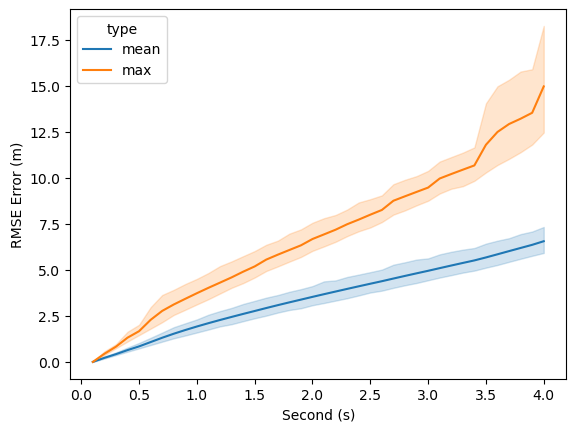

In [20]:
criterion = nn.MSELoss(reduction="none")

steps = []
loss = []
max_loss = []
for step in range(1, future_steps+1):
    raw_rmse_loss = criterion(predictions[:, :step, :], truths[:, :step, :])
    raw_rmse_loss = torch.sqrt(torch.sum(raw_rmse_loss, dim=-1))
    mean_rmse_loss = raw_rmse_loss.mean(dim=-1)
    max_rmse_loss = raw_rmse_loss.max(dim=-1).values
    loss.append(mean_rmse_loss)
    max_loss.append(max_rmse_loss)
    steps.extend([step] * len(mean_rmse_loss))
    
max_loss = torch.cat(max_loss).cpu().numpy()
loss = torch.cat(loss).cpu().numpy()

df = pd.DataFrame({'Second (s)': steps, 'loss': loss})
df1 = pd.DataFrame({'Second (s)': steps, 'loss': max_loss})
df['type'] = 'mean'
df1['type'] = 'max'
df = pd.concat([df, df1])


df['RMSE Error (m)'] = df['loss'] / 100 # to meters
df['Second (s)'] = df['Second (s)'] / 10 # to seconds
sns.lineplot(data = df, x='Second (s)', y='RMSE Error (m)', hue='type',) #  errorbar=('sd', 1),
plt.savefig(f'../model/{model_name}/{folder_name}/res.png')
plt.show()

In [15]:
exp_results = df.groupby(by=['Second (s)', 'type']).mean().unstack()['RMSE Error (m)']
exp_results.to_csv(f'../model/{model_name}/{folder_name}/result.csv')
exp_results

type,max,mean
Second (s),,
0.1,0.548230,0.548230
0.2,0.934171,0.536876
0.3,1.392358,0.567279
0.4,1.604216,0.523036
0.5,1.815371,0.497163
0.6,2.024293,0.480105
0.7,2.219446,0.466605
0.8,2.614821,0.482249
0.9,2.831122,0.474742


### Export JIT Model

Integrate partial of data processing into the model

In [40]:
# # EXPORT_MODEL = True

# # # model.load_state_dict(torch.load("/home/shaoze/Documents/Boeing/Boeing-Trajectory-Prediction/model/Jul09_20-37-37/model_40000.pt"))
# # if EXPORT_MODEL:
# #     model.eval()
# #     model.to('cpu')
# #     script_module = torch.jit.script(model)
# #     os.makedirs(f'../model/exported/', exist_ok=True)
# #     script_module.save("../exported/model_tft_vqvae_cpu.pt")

# stats = {}
# '''
# mean: tensor[]
# '''

# for keys, values in stats_dict.items():
#     stats[keys] = torch.tensor(values.to_list()).view(1,1,-1)
    
# class TFT_EXP(nn.Module):
#     def __init__(self, model:EnhancedTFT, stats:dict):
#         super(TFT_EXP, self).__init__()
#         self.stats = stats
#         self.register_buffer('mean', self.stats['mean'])
#         self.register_buffer('std', self.stats['std'])
#         self.register_buffer('min', self.stats['min'])
#         self.register_buffer('max', self.stats['max'])
#         self.TFT = model
#         self.num_steps = model.num_steps
#         self.num_outputs = model.num_outputs # =2

#     def forward(self, x, mask: Optional[torch.Tensor]=None):
#         single = False
#         if len(x.shape) == 2:
#             x = x.unsqueeze(0)
#             single = True
        
#         # normalize
#         x = (x - self.mean) / self.std
#         x = (x - self.min) / (self.max - self.min)
#         # residual
#         current_pos_input = x[:, -1, :2].clone().unsqueeze(1).repeat(1, x.shape[1], 1)
#         current_pos_output = x[:, -1, :2].clone().unsqueeze(1).repeat(1, self.num_steps, 1)
#         x[:, :, :2] = x[:, :, :2] - current_pos_input
        
#         # pass through TFT
#         outputs, vq_loss, perplexity = self.TFT(x, mask)
#         outputs = outputs.detach()
        
#         # de-residual
#         outputs[:, :, :2] = outputs[:, :, :2] + current_pos_output
        
#         # denormalize
#         outputs = outputs * (self.max[:,:,:self.num_outputs] - self.min[:,:,:self.num_outputs]) + self.min[:,:,:self.num_outputs]
#         outputs = outputs * self.std[:,:,:self.num_outputs] + self.mean[:,:,:self.num_outputs]
        
#         if single:
#             outputs = outputs.squeeze(0)
#         return outputs

# tft_exp = TFT_EXP(model, stats)
# tft_exp.to('cpu')
# tft_exp.eval()
# # script_module = torch.jit.script(tft_exp)
# # os.makedirs(f'../model/exported/', exist_ok=True)
# # script_module.save("../exported/model_tft_vqvae_cpu_preproc.pt")

# # export to onnx

# dummy_input = torch.randn(1, lookback, feature_dim)
# print(f"Input shape: {dummy_input.shape}")

# # Export the wrapped model to ONNX format
# torch.onnx.export(
#     tft_exp,                   # Wrapped model to export
#     dummy_input,                     # Model input
#     "../exported/tft_1111.onnx",              # Output file name
#     export_params=True,              # Store the trained parameter weights inside the model file
#     opset_version=13,                # Set the ONNX opset version (adjust as needed)
#     do_constant_folding=True,        # Whether to execute constant folding for optimization
#     input_names=['input'],           # The model's input names
#     output_names=['output'],         # The model's output names
#     # dynamic_axes={
#     #     'input': {0: 'batch_size'},  # Dynamic batch_size and sequence_length
#     #     'output': {0: 'batch_size'}  # Dynamic batch_size for the output
#     # }
# )
        

In [41]:
# import onnxruntime as ort
# import numpy as np

# # Path to your ONNX model
# model_path = "../exported/tft_1111.onnx"

# # Create an inference session
# session = ort.InferenceSession(model_path)

# # Get the name of the input node
# input_name = session.get_inputs()[0].name

# for file in os.listdir(dir):
#     if file.endswith('.pkl'):
#         df = process_data(dir+file)
#     break

# df = df[['User_X', 'User_Y', 'AGV_distance_X', 'AGV_distance_Y', 'AGV_speed_X',
#        'AGV_speed_Y', 'AGV_speed', 'User_speed_X', 'User_speed_Y',
#        'User_speed', 'User_velocity_X', 'User_velocity_Y', 'Wait_time',
#        'intent_to_cross', 'Gazing_station', 'possible_interaction',
#        'facing_along_sidewalk', 'facing_to_road', 'On_sidewalks', 'On_road',
#        'closest_station', 'distance_to_closest_station',
#        'distance_to_closest_station_X', 'distance_to_closest_station_Y',
#        'looking_at_AGV', 'GazeDirection_X', 'GazeDirection_Y',
#        'GazeDirection_Z', 'AGV_X', 'AGV_Y',
#        'looking_at_closest_station']]

# start_idx = 100
# input = df.iloc[200:200+lookback].astype(np.float32).values

# # add batch
# input = input[np.newaxis, :, :]
# # Run the model
# output = session.run(None, {input_name: input.astype(np.float32)})[0]

# output



### Save data (for interactive visualization)

In [42]:
# model = torch.jit.load("../exported/model_tft_vqvae_cpu.pt")

# test_ds = MyDataset(lookback=lookback)
# all_ds = ds.dataset
# test_ds.dataset = all_ds[len(all_ds)//10 :] # load the last 10% of the data
# X_list, y_list = test_ds.generate_data(return_list=True, future_steps=future_steps)


In [43]:
# from torch.utils.data import DataLoader, Dataset, TensorDataset

# normalize_dict = stats_dict
# pred_data = []
# truth_data = []
# input_data = []
# model.eval()
# device = 'cpu'
# for i, (X, y) in enumerate(zip(X_list, y_list)):
#     current_pos_input = X[:, -1, :2].clone().unsqueeze(1).repeat(1, lookback, 1)
#     current_pos_output = X[:, -1, :2].clone().unsqueeze(1).repeat(1, future_steps, 1).to(device)
#     X[:, :, :2] = X[:, :, :2] - current_pos_input

#     predictions = model(X.float().to(device))[0][:, :future_steps, :2]
#     predictions = predictions + current_pos_output
#     predictions = predictions.to('cpu')
    
#     truths = y[:, :future_steps, :2]
#     X[:, :, :2] = X[:, :, :2] + current_pos_input
#     model_input = X.float().to(device)[:, :lookback, :2]
#     trajectory_id = i
    
#     # reverse normalization
#     for idx, key_ in enumerate(["User_X", "User_Y"]):
#         predictions[:, :, idx] = predictions[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
#         predictions[:, :, idx] = predictions[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
#         truths[:, :, idx] = truths[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
#         truths[:, :, idx] = truths[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
#         model_input[:, :, idx] = model_input[:, :, idx] * (normalize_dict['max'][key_] - normalize_dict['min'][key_]) + normalize_dict['min'][key_]
#         model_input[:, :, idx] = model_input[:, :, idx] * normalize_dict['std'][key_] + normalize_dict['mean'][key_]
    
#     for group_id in range(predictions.shape[0]):
#         for time_step in range(predictions.shape[1]):
#             pred_x, pred_y = predictions[group_id, time_step]
#             pred_data.append([trajectory_id, group_id, time_step, pred_x.item(), pred_y.item()])

#             truth_x, truth_y = truths[group_id, time_step]
#             truth_data.append([trajectory_id, group_id, time_step, truth_x.item(), truth_y.item()])
        
#         for time_step in range(lookback):
#             input_x, input_y = model_input[group_id, time_step]
#             input_data.append([trajectory_id, group_id, time_step, input_x.item(), input_y.item()])
            

# pred_df = pd.DataFrame(pred_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])
# truth_df = pd.DataFrame(truth_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])
# input_df = pd.DataFrame(input_data, columns=['trajectory_id', 'Group_ID', 'Time_Step', 'X', 'Y'])


In [44]:
# files_to_remove = [
#     "../data/pred_tra_all.pkl",
#     "../data/truth_tra_all.pkl", 
#     "../data/input_tra_all.pkl"
# ]

# for file_path in files_to_remove:
#     if os.path.exists(file_path):
#         os.remove(file_path)

# truth_df.to_pickle("../data/truth_tra_all.pkl")
# pred_df.to_pickle("../data/pred_tra_all.pkl")
# input_df.to_pickle("../data/input_tra_all.pkl")